In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# pip install numpy==1.23.3

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


In [5]:
print(tf.config.list_physical_devices())
print(np.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1.23.3


In [6]:
print(tf.__version__)

2.15.0


In [7]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data,dtype="object")

In [8]:
train = get_training_data('/content/drive/MyDrive/pneumonia_data/train')
test = get_training_data('/content/drive/MyDrive/pneumonia_data/test')
val = get_training_data('/content/drive/MyDrive/pneumonia_data/val')

<Axes: xlabel='count'>

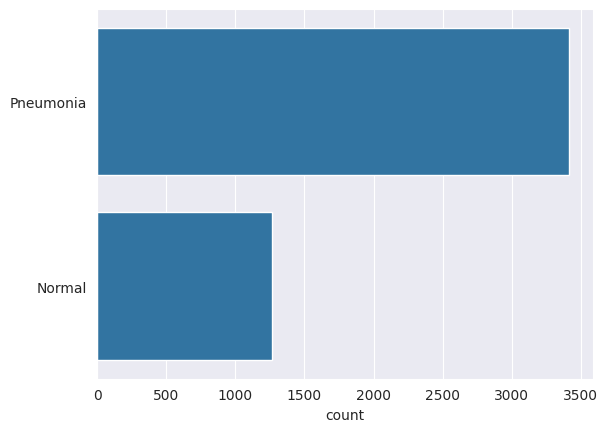

In [9]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'NORMAL')

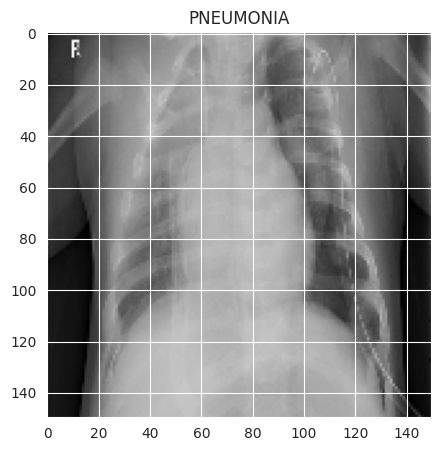

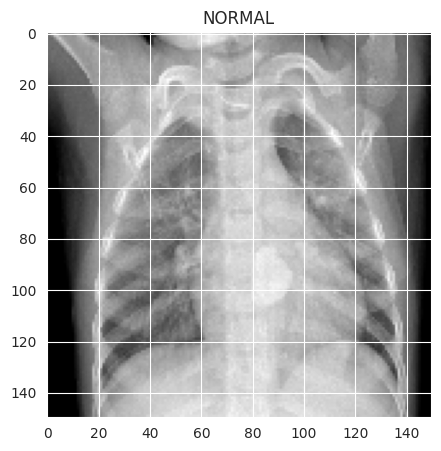

In [10]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [11]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [12]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [13]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

print("Count before augmentation:", len(x_train))

Count before augmentation: 4684


In [14]:
print(np.__version__)

1.23.3


In [15]:
# pip install numpy==1.23.3

In [18]:
def load_augmented_data(augmented_dir, label, img_size):
    augmented_data = []
    for img in os.listdir(augmented_dir):
        try:
            img_arr = cv2.imread(os.path.join(augmented_dir, img), cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            augmented_data.append([resized_arr, label])
        except Exception as e:
            print(e)
    return np.array(augmented_data)

# Define parameters
save_dir = '/content/drive/MyDrive/pneumonia_data/augmented_normal/NORMAL'  # Directory to save augmented images
label = 'NORMAL'  # Class label to augment
img_size = 150  # Image size (adjust if different)
additional_images_needed = 2690  # Number of additional images needed
batch_size = 32  # Number of images to generate per original image

# Load augmented 'Normal' images (assuming label for 'Normal' is 1)
augmented_normal_data = load_augmented_data(save_dir, label=1, img_size=img_size)

# Convert to appropriate format and normalize
x_augmented_normal = np.array([i[0] for i in augmented_normal_data]) / 255
x_augmented_normal = x_augmented_normal.reshape(-1, img_size, img_size, 1)
y_augmented_normal = np.array([i[1] for i in augmented_normal_data])

# Append to existing training data
x_train = np.concatenate((x_train, x_augmented_normal), axis=0)
y_train = np.concatenate((y_train, y_augmented_normal), axis=0)

# Shuffle the dataset
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

# Count after augmentation
print("Count after augmentation:", len(x_train))



<ipython-input-18-a42946c7df30>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(augmented_data)


Count after augmentation: 7069


# Optimization

In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

class CNN(Sequential):
    def __init__(self, nfilters, sfilters):
        super().__init__()
        tf.random.set_seed(0)
        self.add(Conv2D(nfilters[0], kernel_size=(sfilters[0], sfilters[0]), padding='same', activation='relu', input_shape=(150, 150, 1)))
        self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        self.add(Conv2D(nfilters[1], kernel_size=(sfilters[1], sfilters[1]), padding='same', activation='relu'))
        self.add(Dropout(0.1))
        self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        self.add(Conv2D(nfilters[2], kernel_size=(sfilters[2], sfilters[2]), padding='same', activation='relu'))
        self.add(Dropout(0.2))
        self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        self.add(Flatten())
        self.add(Dropout(0.2))
        self.add(Dense(128, activation='relu'))
        self.add(Dense(units=1, activation='sigmoid'))
        self.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
class Genetic:
    def __init__(self, pop_size, nlayers, max_nfilters, max_sfilters):
        self.pop_size = pop_size
        self.nlayers = nlayers
        self.max_nfilters = max_nfilters
        self.max_sfilters = max_sfilters
        self.max_acc = 0
        self.best_arch = np.zeros((1, 6))
        self.gen_acc = []


    # def generate_population(self):
    #     np.random.seed(0)

    #     # Membuat partisi untuk nfilter
    #     partition_size_nfilter = self.max_nfilters // self.pop_size
    #     pop_nlayers = np.array([
    #         np.random.randint(1 + i * partition_size_nfilter, (i + 1) * partition_size_nfilter, self.nlayers)
    #         for i in range(self.pop_size)
    #     ])

    #     # Membuat partisi untuk sfilter
    #     partition_size_sfilter = self.max_sfilters // self.pop_size
    #     pop_sfilters = np.array([
    #         np.random.randint(1 + i * partition_size_sfilter, (i + 1) * partition_size_sfilter, self.nlayers)
    #         for i in range(self.pop_size)
    #     ])

    #     # Menggabungkan kedua set parameter
    #     pop_total = np.concatenate((pop_nlayers, pop_sfilters), axis=1)
    #     return pop_total

    def generate_unique_values(self, max_value, taken_values):
        partition_size = max_value // self.nlayers
        unique_values = []
        for j in range(self.nlayers):
            start = j * partition_size + 1
            if j == self.nlayers - 1:  # Ensure the last partition reaches the max value
                end = max_value + 1
            else:
                end = start + partition_size

            # Generate a unique value within the partition
            value = np.random.randint(start, end)
            while value in taken_values:  # Ensure uniqueness
                value += 1
                if value >= end:  # Reset if exceeds partition
                    value = start

            taken_values.add(value)
            unique_values.append(value)

        return unique_values

    def generate_population(self):
        np.random.seed(0)

        # Initialize population array
        pop_total = np.zeros((self.pop_size, self.nlayers * 2), dtype=int)

        for i in range(self.pop_size):
            taken_values_nfilters = set()
            taken_values_sfilters = set()

            # Generate unique nfilters and sfilters for each individual
            nfilters = self.generate_unique_values(self.max_nfilters, taken_values_nfilters)
            sfilters = self.generate_unique_values(self.max_sfilters, taken_values_sfilters)

            # Combine nfilters and sfilters for the individual
            pop_total[i] = nfilters + sfilters

        return pop_total


    def select_parents(self, pop, nparents, fitness):
        parents = np.zeros((nparents, pop.shape[1]))
        for i in range(nparents):
            best = np.argmax(fitness)
            parents[i] = pop[best]
            fitness[best] = -99999
        return parents

    def crossover(self, parents):
        nchild = self.pop_size - parents.shape[0]
        nparents = parents.shape[0]
        child = np.zeros((nchild, parents.shape[1]))
        for i in range(nchild):
            first = i % nparents
            second = (i + 1) % nparents
            child[i, :2] = parents[first][:2]
            child[i, 2] = parents[second][2]
            child[i, 3:5] = parents[first][3:5]
            child[i, 5] = parents[second][5]
        return child

    def mutation(self, child):
        for i in range(child.shape[0]):
            val = np.random.randint(1, 6)
            ind = np.random.randint(1, 4) - 1
            if child[i][ind] + val > 100:
                child[i][ind] -= val
            else:
                child[i][ind] += val
            val = np.random.randint(1, 4)
            ind = np.random.randint(4, 7) - 1
            if child[i][ind] + val > 20:
                child[i][ind] -= val
            else:
                child[i][ind] += val
        return child

    def fitness(self, pop, X, Y, epochs):
        pop_acc = []
        for i in range(pop.shape[0]):
            nfilters = pop[i][0:3]
            sfilters = pop[i][3:]
            model = CNN(nfilters, sfilters)
            learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)
            history = model.fit(X, Y, batch_size=64, epochs=epochs, validation_data=[x_val, y_val], callbacks=[learning_rate_reduction])
            acc = max(history.history['accuracy'])
            pop_acc.append(acc * 100)
        if max(pop_acc) > self.max_acc:
            self.max_acc = max(pop_acc)
            self.best_arch = pop[np.argmax(pop_acc)]
        self.gen_acc.append(max(pop_acc))
        return pop_acc

    def smooth_curve(self, factor, gen):
        smoothed_points = []
        for point in self.gen_acc:
            if smoothed_points:
                prev = smoothed_points[-1]
                smoothed_points.append(prev * factor + point * (1 - factor))
            else:
                smoothed_points.append(point)
        plt.plot(range(gen + 1), smoothed_points, 'g', label='Smoothed training acc')
        plt.xticks(np.arange(gen + 1))
        plt.legend()
        plt.title('Fitness Accuracy vs Generations')
        plt.xlabel('Generations')
        plt.ylabel('Fitness (%)')
        plt.show()

In [21]:
pop_size = 10
nlayers = 3
max_nfilters = 100
max_sfilters = 10
epochs = 10
num_generations = 20

genCNN = Genetic(pop_size, nlayers, max_nfilters, max_sfilters)
# pop = genCNN.generate_population()
pop = np.array([[44, 36, 80,  6,  8, 20],
       [43, 36, 83,  4,  8, 20],
       [40, 44, 80,  4, 13, 20],
       [38, 41, 84,  5, 10, 20],
       [40, 44, 84,  5, 13, 20],
       [44, 40, 83,  8,  8, 20],
       [43, 36, 82,  4,  8, 19],
       [42, 44, 84,  6, 13, 20],
       [43, 41, 84,  5, 11, 20],
       [40, 45, 80,  5, 14, 20]])


# pop = np.array(result_pop)

pop

array([[44, 36, 80,  6,  8, 20],
       [43, 36, 83,  4,  8, 20],
       [40, 44, 80,  4, 13, 20],
       [38, 41, 84,  5, 10, 20],
       [40, 44, 84,  5, 13, 20],
       [44, 40, 83,  8,  8, 20],
       [43, 36, 82,  4,  8, 19],
       [42, 44, 84,  6, 13, 20],
       [43, 41, 84,  5, 11, 20],
       [40, 45, 80,  5, 14, 20]])

In [22]:
with tf.device('/cpu:0'):
   x = tf.convert_to_tensor(x_train, np.float32)
   y = tf.convert_to_tensor(y_train, np.float32)

bestModelEachGeneration = []

for i in range(num_generations + 1):
    print(pop)
    pop_acc = genCNN.fitness(pop, x, y, epochs)
    print('Best Accuracy at the generation {}: {}'.format(i, genCNN.max_acc))
    parents = genCNN.select_parents(pop, 5, pop_acc.copy())
    child = genCNN.crossover(parents)
    child = genCNN.mutation(child)
    pop = np.concatenate((parents, child), axis=0).astype('int')
    bestModelEachGeneration.append(genCNN.best_arch)


Streaming output truncated to the last 5000 lines.
111/111 [==============================] - 4s 33ms/step - loss: 0.6928 - accuracy: 0.5165 - val_loss: 0.7023 - val_accuracy: 0.2701 - lr: 0.0010
Epoch 3/10
111/111 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5165
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
111/111 [==============================] - 4s 33ms/step - loss: 0.6927 - accuracy: 0.5165 - val_loss: 0.7064 - val_accuracy: 0.2701 - lr: 0.0010
Epoch 4/10
111/111 [==============================] - 4s 33ms/step - loss: 0.6926 - accuracy: 0.5165 - val_loss: 0.7069 - val_accuracy: 0.2701 - lr: 3.0000e-04
Epoch 5/10
111/111 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.5165
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
111/111 [==============================] - 4s 33ms/step - loss: 0.6926 - accuracy: 0.5165 - val_loss: 0.7073 - val_accuracy: 0.2701 - lr: 3.0000e-04
Epoch 

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/cnn_205/conv2d_616/Conv2D/Conv2DBackpropInput defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-22-f68f58fdd20f>", line 9, in <cell line: 7>

  File "<ipython-input-20-fa3d34b1078e>", line 119, in fitness

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 543, in minimize

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients

OOM when allocating tensor with shape[64,54,75,75] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/cnn_205/conv2d_616/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1418703]

ValueError: x and y must have same first dimension, but have shapes (21,) and (20,)

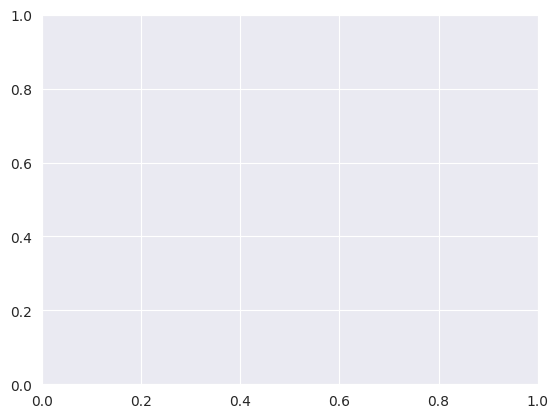

In [23]:
genCNN.smooth_curve(0.5,num_generations)

In [24]:
genCNN.best_arch

array([45, 37, 85,  4, 10, 20])

In [25]:
genCNN.max_acc

99.54732060432434

In [26]:
genCNN.gen_acc

[99.17951822280884,
 99.46244359016418,
 99.17951822280884,
 99.37756657600403,
 99.4200050830841,
 99.25024509429932,
 99.25024509429932,
 99.54732060432434,
 99.0663468837738,
 99.0663468837738,
 99.46244359016418,
 98.86829853057861,
 99.53317046165466,
 98.93903136253357,
 99.25024509429932,
 99.080491065979,
 99.46244359016418,
 99.15122389793396,
 99.20780658721924,
 99.19366240501404]

In [27]:
bestModelEachGeneration

[array([40, 44, 84,  5, 13, 20]),
 array([44, 36, 84,  4,  8, 18]),
 array([44, 36, 84,  4,  8, 18]),
 array([44, 36, 84,  4,  8, 18]),
 array([44, 36, 84,  4,  8, 18]),
 array([44, 36, 84,  4,  8, 18]),
 array([44, 36, 84,  4,  8, 18]),
 array([45, 37, 85,  4, 10, 20]),
 array([45, 37, 85,  4, 10, 20]),
 array([45, 37, 85,  4, 10, 20]),
 array([45, 37, 85,  4, 10, 20]),
 array([45, 37, 85,  4, 10, 20]),
 array([45, 37, 85,  4, 10, 20]),
 array([45, 37, 85,  4, 10, 20]),
 array([45, 37, 85,  4, 10, 20]),
 array([45, 37, 85,  4, 10, 20]),
 array([45, 37, 85,  4, 10, 20]),
 array([45, 37, 85,  4, 10, 20]),
 array([45, 37, 85,  4, 10, 20]),
 array([45, 37, 85,  4, 10, 20])]

In [28]:
# Next pop
# for gen 11
# array([[38, 47, 79,  4,  5, 13],
#        [37, 47, 77,  4,  4, 11],
#        [32, 52, 79,  4,  4, 12],
#        [32, 47, 78,  4,  4,  6],
#        [40, 51, 77,  5,  9, 11],
#        [40, 47, 77,  4,  5, 13],
#        [37, 47, 81,  7,  4, 12],
#        [32, 52, 83,  4,  4,  7],
#        [32, 47, 79,  7,  4, 11],
#        [40, 51, 82,  5,  9, 14]])

# for gen 21
pop

array([[54, 41, 92,  6, 16, 20],
       [54, 44, 94, 10, 14, 19],
       [54, 44, 87,  8, 14, 20],
       [54, 39, 92, 11, 14, 20],
       [58, 41, 87,  4, 14, 19],
       [54, 45, 94,  9, 16, 19],
       [54, 44, 88, 10, 14, 19],
       [54, 46, 92,  8, 15, 20],
       [54, 39, 90, 12, 14, 19],
       [58, 46, 92,  4, 14, 18]])

# Optimized Model

In [29]:
bestParam = genCNN.best_arch
# bestParam = [35, 64, 98,  7,  8, 17]
# array([38, 47, 79,  4,  5, 13]) Gen 1 ~ 10
# array([35, 64, 98,  7,  8, 17]) Gen 21 ~ 30
bestParam

array([45, 37, 85,  4, 10, 20])

In [30]:
model = Sequential()
model.add(Conv2D(bestParam[0] , (bestParam[3],bestParam[3]) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(bestParam[1] , (bestParam[4],bestParam[4]) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(bestParam[2] , (bestParam[5],bestParam[5]) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_618 (Conv2D)         (None, 150, 150, 45)      765       
                                                                 
 max_pooling2d_618 (MaxPool  (None, 75, 75, 45)        0         
 ing2D)                                                          
                                                                 
 conv2d_619 (Conv2D)         (None, 75, 75, 37)        166537    
                                                                 
 dropout_618 (Dropout)       (None, 75, 75, 37)        0         
                                                                 
 max_pooling2d_619 (MaxPool  (None, 38, 38, 37)        0         
 ing2D)                                                          
                                                                 
 conv2d_620 (Conv2D)         (None, 38, 38, 85)        1

In [31]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [32]:
history = model.fit(x_train,y_train, batch_size = 64 ,epochs = 10 , validation_data = [x_val, y_val] ,callbacks = [learning_rate_reduction])

Epoch 1/10


ResourceExhaustedError: Graph execution error:

Detected at node sequential/conv2d_618/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-32-1a0b18bca590>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/activations.py", line 306, in relu

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5395, in relu

OOM when allocating tensor with shape[64,150,150,45] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/conv2d_618/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1420978]

In [ ]:
# Adjust the range to match the number of epochs in your history data
epochs = [i for i in range(len(history.history['accuracy']))]

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()


In [ ]:
predictions = model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

In [ ]:
from sklearn.metrics import classification_report

# Assuming predictions are probabilities, convert them to binary labels
binary_predictions = [1 if i > 0.5 else 0 for i in predictions]

# Generate a classification report
print(classification_report(y_test, binary_predictions, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))


In [ ]:
cm = confusion_matrix(y_test,binary_predictions)
cm

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)